In [65]:
import os
import glob as gb
from PIL import Image 
from tqdm import tqdm 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score 

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam , lr_scheduler 
import torchvision 
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [141]:
main_path = os.path.join("/Users", "jcheigh", "Desktop", "Important Info", "Lung and Colon Cancer Classification")
code_path = os.path.join(main_path, "Cancer Classification")
data_path = os.path.join(main_path, "Data", "Colon Images") 

In [142]:
classes = list({cat for cat in os.listdir(data_path) if 'colon' in cat})
labels   = {cat : i for i, cat in enumerate(classes)}
get_label = lambda i : classes[i]

In [144]:
data_path_lst = []
data_labels   = []

for folder in os.listdir(data_path):
    if 'colon' in folder:
        files = gb.glob(pathname = f"{data_path}/{folder}/*.jpeg")
        for file in files:
            data_path_lst.append(file)
            data_labels.append(labels[folder])

In [145]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
                                                        data_path_lst,
                                                        data_labels,
                                                        test_size = .2,
                                                        random_state = 1        
                                                        )

In [146]:
img_size = 256
transform = transforms.Compose(
    [   
        transforms.Resize(size = (img_size, img_size)),
        transforms.ToTensor()
    ]
)

class Data(Dataset):

    def __init__(self, path_lst, label_lst, transform):
        self.path_lst = path_lst
        self.label_lst = label_lst
        self.transform = transform

    def __len__(self):
        return len(self.path_lst)

    def __getitem__(self, idx):
        path = self.path_lst[idx]
        img = Image.open(path)
        transformed_img = self.transform(img)
        label = self.label_lst[idx]

        return transformed_img, label

In [147]:
train = Data(train_paths, train_labels, transform)
test  = Data(test_paths, test_labels, transform)

In [148]:
batch_size = 128

train_dataloader = DataLoader(
        dataset = train,
        batch_size = batch_size,
        shuffle = True
        )

test_dataloader = DataLoader(
        dataset = test,
        batch_size = batch_size,
        shuffle = True
        )

X_smpl, y_smpl = next(iter(train_dataloader))
print(f"Image Shape: {X_smpl.shape}, Label Shape: {y_smpl.shape}")

Image Shape: torch.Size([128, 3, 256, 256]), Label Shape: torch.Size([128])


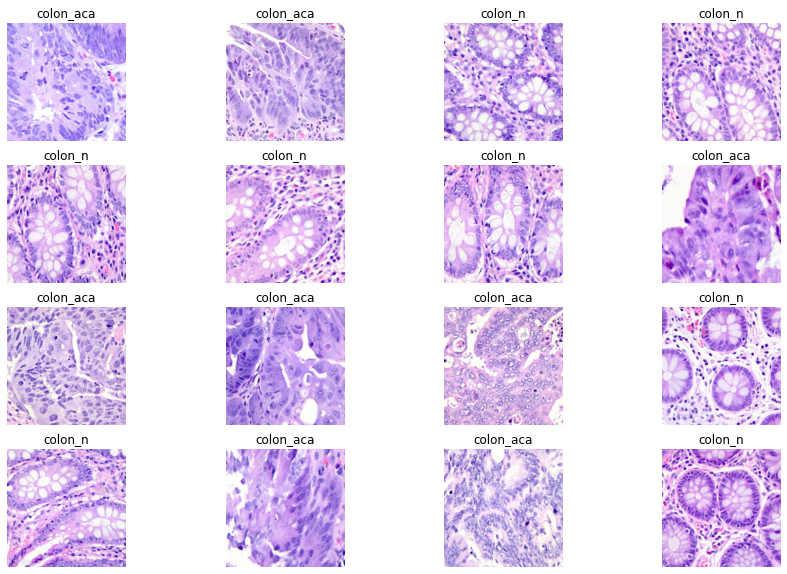

In [149]:
fig, axis = plt.subplots(4, 4, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = X_smpl[i].numpy()
        img = np.transpose(img, (1, 2, 0)) # torch/numpy convention
        ax.imshow(img)
        ax.set(title = f'{get_label(y_smpl[i])}')
        ax.axis('off')

In [150]:
X_smpl.size() # B x C x D x D

torch.Size([128, 3, 256, 256])

In [151]:
class ConvNet(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(
                in_channels = 3,
                out_channels = 16,
                kernel_size = 3,
                padding = 1,
                stride = 2
                )
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 3,
                padding = 1,
                stride = 2
                )
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(
                in_channels = 32,
                out_channels = 64,
                kernel_size = 3,
                padding = 1,
                stride = 2
                )
        self.pool3 = nn.MaxPool2d(2)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(
                        in_features = 64 * 4 * 4,
                        out_features = num_classes
                        )

    def forward(self, x):
        # x.size() = 128 x 3 x 256 x 256 
        x = self.relu(self.conv1(x))
        # x.size() = 128 x 16 x 128 x 128
        x = self.pool1(x)
        # x.size() = 128 x 16 x 64 x 64
        x = self.relu(self.conv2(x))
        # x.size() = 128 x 32 x 32 x 32
        x = self.pool2(x)
        # x.size() = 128 x 32 x 16 x 16
        x = self.relu(self.conv3(x))
        # x.size() = 128 x 64 x 8 x 8
        x = self.pool3(x)
        # x.size() = 128 x 64 x 4 x 4
        x = self.flatten(x)
        # x.size() = 128 x 1024
        x = self.linear(x)
        # x.size() = 128 x 2
        return x


In [152]:
model = ConvNet(2)
criterion = nn.CrossEntropyLoss()
optimizer= Adam(model.parameters(),lr=0.001)


In [155]:
epochs = 10 
training_acc = [] 
training_loss = [] 

for i in tqdm(range(epochs)) : 
    epoch_loss = 0 
    epoch_acc = 0 
    
    for batch, (x_train, y_train) in enumerate(train_dataloader):
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train) 
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 
    
        epoch_loss += loss 
        epoch_acc += accuracy_score(y_train , y_pred.argmax(dim=1))
        
    training_loss.append((epoch_loss/len(train_dataloader)).detach().numpy())
    training_acc.append(epoch_acc/len(train_dataloader))
    
    print(f"Epoch {i}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")


 10%|█         | 1/10 [01:16<11:24, 76.01s/it]

Epoch 0: Accuracy: 94.54365079365078, Loss: 0.13949687778949738




 20%|██        | 2/10 [02:30<10:01, 75.24s/it]

Epoch 1: Accuracy: 92.9439484126984, Loss: 0.1696067452430725




 30%|███       | 3/10 [03:45<08:44, 74.98s/it]

Epoch 2: Accuracy: 95.06448412698413, Loss: 0.12809142470359802




 40%|████      | 4/10 [04:58<07:25, 74.24s/it]

Epoch 3: Accuracy: 95.16369047619048, Loss: 0.11749289184808731




 50%|█████     | 5/10 [06:11<06:08, 73.75s/it]

Epoch 4: Accuracy: 95.3373015873016, Loss: 0.1182565987110138




 60%|██████    | 6/10 [11:51<10:57, 164.30s/it]

Epoch 5: Accuracy: 95.22569444444444, Loss: 0.12121482938528061




 70%|███████   | 7/10 [13:05<06:44, 134.67s/it]

Epoch 6: Accuracy: 96.6641865079365, Loss: 0.08862004429101944




 80%|████████  | 8/10 [14:17<03:49, 114.78s/it]

Epoch 7: Accuracy: 95.43650793650794, Loss: 0.10905302315950394




 90%|█████████ | 9/10 [15:28<01:41, 101.14s/it]

Epoch 8: Accuracy: 95.58531746031747, Loss: 0.11684341728687286




100%|██████████| 10/10 [16:45<00:00, 100.58s/it]

Epoch 9: Accuracy: 97.0734126984127, Loss: 0.08254572749137878


